In [2]:
!pip install tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

plt.style.use("default")
np.set_printoptions(precision=4, suppress=True)


In [13]:
def simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths, q=0.0, seed=None):
    """
    Simulate GBM paths under risk-neutral dynamics:
      dS = (r - q) S dt + sigma S dW
    using log-Euler scheme.
    Returns array: shape (n_paths, n_steps+1)
    """
    if seed is not None:
        np.random.seed(seed)

    dt = T / n_steps
    nudt = (r - q - 0.5 * sigma**2) * dt
    sidt = sigma * np.sqrt(dt)

    Z = np.random.normal(size=(n_paths, n_steps))

    S = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    for t in range(1, n_steps + 1):
        S[:, t] = S[:, t-1] * np.exp(nudt + sidt * Z[:, t-1])
    return S


In [14]:
def price_american_binomial(S0, K, T, r, sigma, n_steps=200, option_type="put"):
    """
    Cox-Ross-Rubinstein binomial tree for American call/put.
    Returns option price at t=0.
    """
    dt = T / n_steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    disc = np.exp(-r * dt)
    p = (np.exp(r * dt) - d) / (u - d)

    # Option values at maturity
    values = np.zeros(n_steps + 1)
    for j in range(n_steps + 1):
        S_T = S0 * (u**j) * (d**(n_steps - j))
        if option_type == "put":
            values[j] = max(K - S_T, 0.0)
        else:
            values[j] = max(S_T - K, 0.0)

    # Backward induction
    for i in range(n_steps - 1, -1, -1):
        for j in range(i + 1):
            S_ij = S0 * (u**j) * (d**(i - j))
            continuation = disc * (p * values[j+1] + (1 - p) * values[j])
            if option_type == "put":
                exercise = max(K - S_ij, 0.0)
            else:
                exercise = max(S_ij - K, 0.0)
            values[j] = max(exercise, continuation)  # American feature
    return values[0]


In [15]:
def lsmc_american_option(
    S0, K, T, r, sigma,
    n_paths=20000,
    n_steps=50,
    q=0.0,
    option_type="put",
    seed=None,
    basis_funcs=None
):
    """
    Longstaff-Schwartz Least Squares Monte Carlo for American options.
    """
    dt = T / n_steps
    disc = np.exp(-r * dt)

    # 1) simulate paths
    S = simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths, q, seed)

    # 2) payoff at each node
    if option_type == "put":
        payoff = np.maximum(K - S, 0.0)
    else:
        payoff = np.maximum(S - K, 0.0)

    # 3) initialize cashflows with payoff at maturity (time step n_steps)
    CF = payoff[:, -1].copy()

    # 4) basis functions for regression
    if basis_funcs is None:
        basis_funcs = [lambda x: np.ones_like(x), lambda x: x, lambda x: x**2]

    # 5) backward induction: from t=n_steps-1 down to t=1
    for t in range(n_steps - 1, 0, -1):
        # discount one step (CF was at time t+1, now PV at time t)
        CF *= disc

        # paths that are in the money at time t
        itm = payoff[:, t] > 0
        if not np.any(itm):
            continue

        # X: basis on S(t) for ITM paths
        X = np.vstack([f(S[itm, t]) for f in basis_funcs]).T
        Y = CF[itm]  # continuation value (discounted CF)

        # regression: Y ≈ X beta
        beta, *_ = np.linalg.lstsq(X, Y, rcond=None)
        continuation = X @ beta

        exercise = payoff[itm, t]
        exercise_now = exercise > continuation

        # update CF: if exercise now, take payoff; else keep continuation CF
        CF[itm] = np.where(exercise_now, exercise, CF[itm])

    # discount once more to t=0
    CF *= disc
    price = CF.mean()
    return price


In [16]:
S0 = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.2
option_type = "put"

binom_price = price_american_binomial(S0, K, T, r, sigma,
                                      n_steps=500,
                                      option_type=option_type)
print("Binomial American price:", binom_price)

lsmc_price = lsmc_american_option(S0, K, T, r, sigma,
                                  n_paths=20000,
                                  n_steps=50,
                                  option_type=option_type,
                                  seed=42)
print("LSMC price:", lsmc_price)

rel_err = abs(lsmc_price - binom_price) / binom_price * 100
print("Relative error (%):", rel_err)


Binomial American price: 6.088810110703037
LSMC price: 6.074465344044806
Relative error (%): 0.23559228153650352


In [17]:
path_grid = [2000, 5000, 10000, 20000, 50000]
lsmc_prices = []

for n_paths in tqdm(path_grid, desc="Convergence paths"):
    price_est = lsmc_american_option(
        S0, K, T, r, sigma,
        n_paths=n_paths,
        n_steps=50,
        option_type=option_type,
        seed=123
    )
    lsmc_prices.append(price_est)

df_conv = pd.DataFrame({"paths": path_grid, "lsmc_price": lsmc_prices})
df_conv["abs_error"] = (df_conv["lsmc_price"] - binom_price).abs()
df_conv["rel_error_pct"] = df_conv["abs_error"] / binom_price * 100
df_conv


Convergence paths: 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


,paths,lsmc_price,abs_error,rel_error_pct
0,2000,6.028284,0.060526,0.994060
1,5000,5.850636,0.238174,3.911674
2,10000,6.039596,0.049214,0.808268
3,20000,6.058975,0.029835,0.489999
4,50000,6.073445,0.015365,0.252344


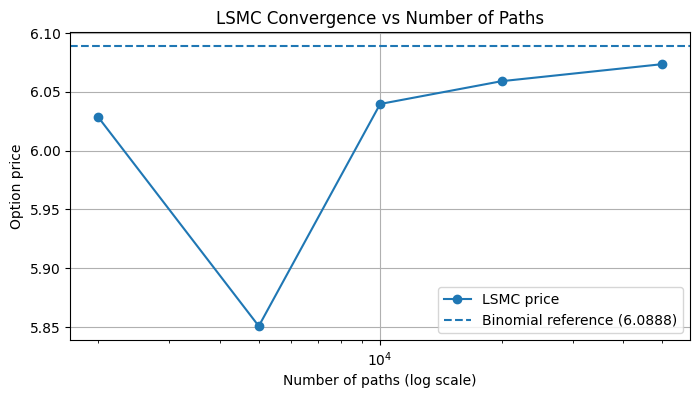

   paths  lsmc_price  abs_error  rel_error_pct
0   2000    6.028284   0.060526       0.994060
1   5000    5.850636   0.238174       3.911674
2  10000    6.039596   0.049214       0.808268
3  20000    6.058975   0.029835       0.489999
4  50000    6.073445   0.015365       0.252344


In [18]:
plt.figure(figsize=(8,4))
plt.plot(df_conv["paths"], df_conv["lsmc_price"], marker="o", label="LSMC price")
plt.axhline(binom_price, linestyle="--",
            label=f"Binomial reference ({binom_price:.4f})")
plt.xscale("log")
plt.xlabel("Number of paths (log scale)")
plt.ylabel("Option price")
plt.title("LSMC Convergence vs Number of Paths")
plt.legend()
plt.grid(True)
plt.show()

print(df_conv)


In [19]:
sigmas = np.linspace(0.1, 0.6, 20)
n_paths = 20000
n_steps = 50

records = []

for sig in tqdm(sigmas, desc="Vol scenarios"):
    binom = price_american_binomial(S0, K, T, r, sig,
                                    n_steps=400,
                                    option_type=option_type)
    lsmc  = lsmc_american_option(S0, K, T, r, sig,
                                 n_paths=n_paths, n_steps=n_steps,
                                 option_type=option_type, seed=42)
    rel_err = abs(lsmc - binom) / binom * 100
    records.append([sig, binom, lsmc, rel_err])

df_vol = pd.DataFrame(records,
                      columns=["sigma", "binomial_price",
                               "lsmc_price", "rel_error_pct"])
df_vol


Vol scenarios: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


,sigma,binomial_price,lsmc_price,rel_error_pct
0,0.100000,2.435738,2.432539,0.131352
1,0.126316,3.369217,3.362555,0.197732
2,0.152632,4.327896,4.315764,0.280304
3,0.178947,5.301928,5.287401,0.273998
4,0.205263,6.285777,6.274701,0.176205
5,0.231579,7.276060,7.265361,0.147050
6,0.257895,8.270508,8.252802,0.214080
7,0.284211,9.267606,9.249531,0.195042
8,0.310526,10.266193,10.269205,0.029343
9,0.336842,11.265447,11.275264,0.087141


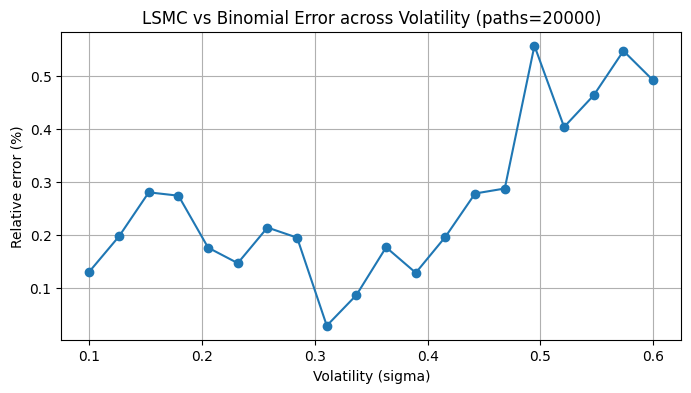

Max relative error across vols: 0.56%
Mean relative error across vols: 0.26%


In [20]:
plt.figure(figsize=(8,4))
plt.plot(df_vol["sigma"], df_vol["rel_error_pct"], marker="o")
plt.xlabel("Volatility (sigma)")
plt.ylabel("Relative error (%)")
plt.title(f"LSMC vs Binomial Error across Volatility (paths={n_paths})")
plt.grid(True)
plt.show()

print("Max relative error across vols: {:.2f}%"
      .format(df_vol["rel_error_pct"].max()))
print("Mean relative error across vols: {:.2f}%"
      .format(df_vol["rel_error_pct"].mean()))
